# Ch 4. Statistical Learning

We will use a set of exploratory features in consumer cedit files and develop a **credit scoring rule** to predict whether the loaner will be considered a good or bad client. 

1. Data Preparation
2. EDA
    - Cramer's V
3. Data Preprocessing
    - Normalization
    - One-hot encoding
    - Shuffle and split
4. Penalized Logistic Regression
    - Ridge
    - Lasso
6. Tree models 
7. Ensemble models
    - Bagging
    - Boosting
    - Random Forests



## 1. Data Preparation

This dataset is from Dr. Hans Hofmann of the University of Hamburg. (source: UCI Machine Learning Repository). 

In [157]:
# importing modules to be used
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image
from __future__ import division

%matplotlib inline


In [146]:
credit = pd.read_table("Data/german.data.txt", 
                       delim_whitespace = True,
                       header = None)

colnames = ["checking_status", "duration", "credit_history", "purpose", "credit_amount",
           "savings", "employment", "installment_rate", "personal_status", "other_parties",
           "residence_since", "property_magnitude", "age", "other_payment_plans", "housing", 
           "existing_credits", "job", "num_dependents", "telephone", "foreign_workder", 
           "class"]

credit.columns = colnames
credit.head(10)

,checking_status,duration,credit_history,purpose,credit_amount,savings,employment,installment_rate,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,telephone,foreign_workder,class
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2
5,A14,36,A32,A46,9055,A65,A73,2,A93,A101,...,A124,35,A143,A153,1,A172,2,A192,A201,1
6,A14,24,A32,A42,2835,A63,A75,3,A93,A101,...,A122,53,A143,A152,1,A173,1,A191,A201,1
7,A12,36,A32,A41,6948,A61,A73,2,A93,A101,...,A123,35,A143,A151,1,A174,1,A192,A201,1
8,A14,12,A32,A43,3059,A64,A74,2,A91,A101,...,A121,61,A143,A152,1,A172,1,A191,A201,1
9,A12,30,A34,A40,5234,A61,A71,4,A94,A101,...,A123,28,A143,A152,2,A174,1,A191,A201,2


In [3]:
n_records = credit.shape[0]

n_good = sum(credit['class'] == 1)
n_bad = sum(credit['class'] == 2)
greater_percent = (n_good / n_records) * 100

print ""
print "Total number of Observations: {}".format(n_records)
print "Individuals credit-worthy: {}".format(n_good)
print "Individuals not credit-worthy: {}".format(n_bad)
print "Percentage of credit-worthy clients: {:.2f}%".format(greater_percent)


Total number of Observations: 1000
Individuals credit-worthy: 700
Individuals not credit-worthy: 300
Percentage of credit-worthy clients: 70.00%


In [4]:
# Re-encoding outcome variable. Good : 0, Bad: 1
y = credit['class'] - 1

# Splitting data into features and target label 
X = credit.drop('class', axis = 1)

## 2. Exploratory Data Analysis
###  1) Factor variables - Cramer's V

** Cramer's V **(1946) measures the correlation between categorical variates. 

$$ V = \sqrt{\frac{\chi ^2}{n(k - 1)}} $$

where chi^2 is the statistics of Pearson's chi-squared test of independencies, `n` is the number of samples and `k` is the number of unique classes for the two variables, whichever less. In our case, `k - 1` is equal to 1 because we have two classes in  output variable. While most of the features are categorical, we have three continuous features, duration, age, and credit amount. For the moment, we are arbitrarily categorizing these continuous features only for the sake of exploratory analysis. 

In [148]:
credit.f = X.copy()
cont = ["duration", "age", "credit_amount"]

# 10 break points for each cont vars
breakpoints = credit.f[cont].quantile(np.linspace(0.0, 1.0, num = 10))

for v in cont:
    credit.f[v] = pd.cut(credit.f[v], bins=breakpoints[v].unique())



In [149]:
feature_names = list(credit.f.columns)
cramer_v = np.zeros(len(feature_names))


for i, feature in enumerate(feature_names):
    cont = pd.crosstab(credit.f[feature], y)
    cramer_v[i] = np.sqrt(stats.chi2_contingency(cont)[0] * .001)
    
cramer_v = pd.Series(cramer_v, index = feature_names)

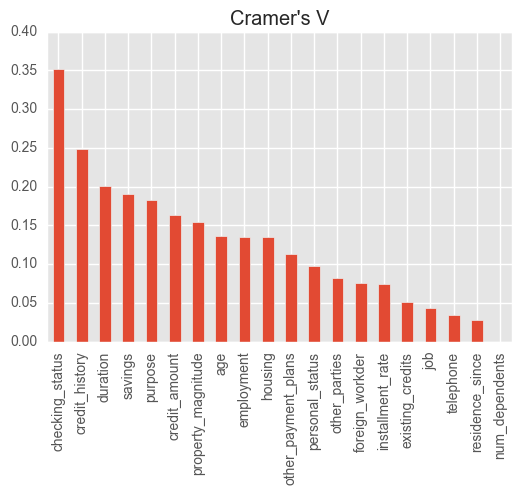

In [150]:
plt.style.use('ggplot')
cramer_v_sorted = cramer_v.sort_values(ascending = False)

plt.figure()
cramer_v_sorted.plot(kind = "bar")
plt.title("Cramer's V")


The sorted Cramer's V values for 20 features are shown above. It appears that the amount in existing checking account, credit history, and credit duration are moderately associated with the output label. 
  

# 3. Data Preprocessing 

## 1) Normalizing numerical features

Three continuouts features, duration, age, and credit amount, are normalized by minmaxscaler so that minimum value has 0 and maximum has 1.  

In [33]:
scaler = MinMaxScaler()
cont = ["duration", "age", "credit_amount"]
X[cont] = scaler.fit_transform(X[cont])
display(X[cont].describe())

,duration,age,credit_amount
count,1000.000000,1000.000000,1000.000000
mean,0.248574,0.295464,0.166241
std,0.177336,0.203133,0.155317
min,0.000000,0.000000,0.000000
25%,0.117647,0.142857,0.061379
50%,0.205882,0.250000,0.113871
75%,0.294118,0.410714,0.204812
max,1.000000,1.000000,1.000000


## 2) One-hot encoding

In [9]:
features = pd.get_dummies(X)
one_hot_encoded = list(features.columns)

print "{} total features after one-hot encoding.".format(len(one_hot_encoded))
print " "
print one_hot_encoded

61 total features after one-hot encoding.
 
['duration', 'credit_amount', 'installment_rate', 'residence_since', 'age', 'existing_credits', 'num_dependents', 'checking_status_A11', 'checking_status_A12', 'checking_status_A13', 'checking_status_A14', 'credit_history_A30', 'credit_history_A31', 'credit_history_A32', 'credit_history_A33', 'credit_history_A34', 'purpose_A40', 'purpose_A41', 'purpose_A410', 'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45', 'purpose_A46', 'purpose_A48', 'purpose_A49', 'savings_A61', 'savings_A62', 'savings_A63', 'savings_A64', 'savings_A65', 'employment_A71', 'employment_A72', 'employment_A73', 'employment_A74', 'employment_A75', 'personal_status_A91', 'personal_status_A92', 'personal_status_A93', 'personal_status_A94', 'other_parties_A101', 'other_parties_A102', 'other_parties_A103', 'property_magnitude_A121', 'property_magnitude_A122', 'property_magnitude_A123', 'property_magnitude_A124', 'other_payment_plans_A141', 'other_payment_plans_A142', 'o

## 3) Shuffle and split data


In [10]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, y,
                                                    test_size = 0.2, 
                                                    random_state = 42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 800 samples.
Testing set has 200 samples.


# 4. Penalized Logistic Regression 

Logistic regression is now the most widely used method in credit scoring. 


## 1) Inference in the logistic model



## 2) Ridge model and Lasso Regression


$$ \hat{\beta(\lambda)} = argmin [ -logL(\beta;y,X) + \frac{\lambda}{n}p(\beta)] $$

$$ p(\beta) = \frac{1 - \alpha}{2} \sum _{k} \beta ^2 _k + \alpha \sum _{k} |\beta_k| $$

where we obtain ridge model when \alpha = 0 (L2 norm) and a lasso model when \alpha = 1 (L1 norm).  

In [151]:
c_range = 10 ** np.linspace(-4, 4, 100)
gs = GridSearchCV(estimator = LogisticRegression(random_state = 12, penalty = 'l2'),
                 param_grid = [{'C': c_range,
                               'penalty': ['l1', 'l2']}], 
                 scoring = 'roc_auc',
                 cv = 10)
gs = gs.fit(X_train, y_train)

print("Train AUC:      %.4f" %gs.best_score_)
print("Optimal C value:      %.4f" %gs.best_params_['C'])
print("Best estimator selected:     ")

Train AUC:      0.7745
Optimal C value:      0.9112
LogisticRegression(C=0.91116275611548958, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=12,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


In [120]:
lasso_std_test_score = gs.cv_results_['std_test_score'][::2]
ridge_std_test_score = gs.cv_results_['std_test_score'][1::2]
lasso_mean_test_score = gs.cv_results_['mean_test_score'][::2]
ridge_mean_test_score = gs.cv_results_['mean_test_score'][1::2]
d = {'c_range': c_range,
    'lasso_mean': lasso_mean_test_score,
    'ridge_mean': ridge_mean_test_score,
    'lasso_std': lasso_std_test_score,
    'ridge_std': ridge_std_test_score,}
df = pd.DataFrame(d)
df.head(10)

,c_range,lasso_mean,lasso_std,ridge_mean,ridge_std
0,0.000100,0.5,0.0,0.516080,0.037293
1,0.000120,0.5,0.0,0.518234,0.037568
2,0.000145,0.5,0.0,0.520763,0.037525
3,0.000175,0.5,0.0,0.524099,0.038618
4,0.000210,0.5,0.0,0.528699,0.038320
5,0.000254,0.5,0.0,0.534419,0.037994
6,0.000305,0.5,0.0,0.539613,0.037660
7,0.000368,0.5,0.0,0.546201,0.037814
8,0.000443,0.5,0.0,0.556207,0.038436
9,0.000534,0.5,0.0,0.565860,0.038979


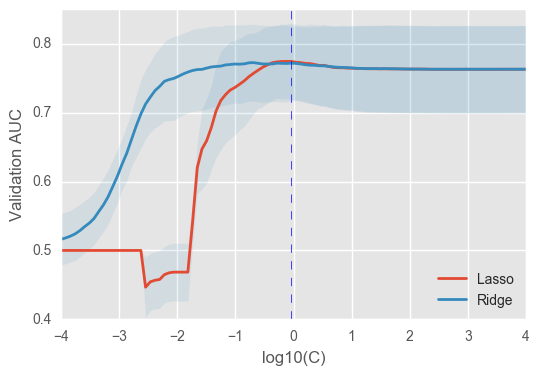

In [153]:
plt.plot(np.linspace(-4, 4, 100), df['lasso_mean'], 
         label = "Lasso", linewidth = 2)
plt.plot(np.linspace(-4, 4, 100), df['ridge_mean'],
        label = "Ridge", linewidth = 2)
plt.fill_between(np.linspace(-4, 4, 100), 
                 df['lasso_mean'] + df['lasso_std'], 
                 df['lasso_mean'] - df['lasso_std'],
                alpha = .1)
plt.fill_between(np.linspace(-4, 4, 100), 
                 df['ridge_mean'] + df['ridge_std'], 
                 df['ridge_mean'] - df['ridge_std'],
                alpha = .1)
plt.axvline(x = np.log10(gs.best_params_['C']), 
            linestyle = "--", linewidth = 0.5)
plt.xlabel("log10(C)")
plt.ylabel("Validation AUC")
plt.legend(loc = "lower right")

The method from scikit learn does not output p-values and confidence intervals. We will build a bootstrap to estimate the confidence interval of coefficients. 

In [232]:
lr_best = gs.best_estimator_
lr_best.fit(X_train, y_train)
lr_best_coef = lr_best.coef_


n_obs = len(X_train)
n_bs = 1000
n_features = 61
bs_coef = np.zeros((61, 1000))

np.random.seed(42)
for n in xrange(n_bs):
    resampled_id = np.random.choice(X_train.index, len(X_train.index), replace = True)
    resampled_X_train = X_train.ix[resampled_id]
    resampled_y_train = y_train.ix[resampled_id]
    lr_best.fit(resampled_X_train, resampled_y_train)
    bs_coef[:, n] = lr_best.coef_


In [240]:
bs_coef = pd.DataFrame(bs_coef)
bs_coef.index = list(features.columns)
bs_mean = bs_coef.mean(axis = 1)
bs_std = bs_coef.std(axis = 1) / np.sqrt(n_bs)
z = (lr_best_coef[0] - bs_mean) / bs_std
p = 2 * (1 - stats.norm.cdf(abs(z)))

res = {'estimate': lr_best_coef[0], 'mean': bs_mean, 'se': bs_std, 
       'z': z, 'p': p}

res = pd.DataFrame(res)
res = res.sort_values('p')

In [241]:
res

,estimate,mean,p,se,z
property_magnitude_A123,-0.001388,-0.054337,0.000000e+00,0.004556,11.621494
employment_A71,0.000000,0.101050,0.000000e+00,0.009411,-10.737048
personal_status_A94,0.000000,-0.069390,0.000000e+00,0.006182,11.224239
purpose_A48,-0.094333,-0.298737,0.000000e+00,0.015124,13.515083
other_parties_A101,0.000000,-0.040850,0.000000e+00,0.004774,8.557299
purpose_A45,0.000000,0.164689,0.000000e+00,0.011314,-14.556148
property_magnitude_A121,-0.302120,-0.368722,0.000000e+00,0.007757,8.586048
property_magnitude_A122,0.000000,-0.050173,0.000000e+00,0.004938,10.159858
purpose_A410,0.000000,-0.118549,0.000000e+00,0.013348,8.881352
personal_status_A93,-0.451009,-0.544231,0.000000e+00,0.007740,12.044069


In [268]:
pred_prob = pd.DataFrame(lr_best.predict_proba(X_test)).iloc[:, 1]
y_hat = ("good", "bad")[pred_prob > 0.5]

TypeError: tuple indices must be integers, not Series

In [267]:
[pred_prob > 0.5]

[0      False
 1       True
 2       True
 3      False
 4      False
 5      False
 6      False
 7      False
 8      False
 9      False
 10     False
 11     False
 12     False
 13      True
 14      True
 15     False
 16     False
 17     False
 18     False
 19     False
 20     False
 21     False
 22     False
 23     False
 24     False
 25      True
 26     False
 27      True
 28     False
 29     False
        ...  
 170    False
 171    False
 172    False
 173    False
 174    False
 175    False
 176    False
 177    False
 178    False
 179     True
 180    False
 181    False
 182    False
 183    False
 184    False
 185    False
 186     True
 187    False
 188    False
 189    False
 190    False
 191    False
 192     True
 193    False
 194    False
 195    False
 196     True
 197     True
 198    False
 199    False
 Name: 1, dtype: bool]